Known:
- Calculated gamma is off -> wrong aeff? -> wrong equation for aeff?
- Spectrum is off -> some paramters are incorrect

Issue:
- Need more steps?
- Resolution?
- equations used for calculating effective area is wrong perhaps? (can't apply weakly guiding approximation?)

To be fix:
- smoothing the GVD curve
- try taking finer steps and resolution

start


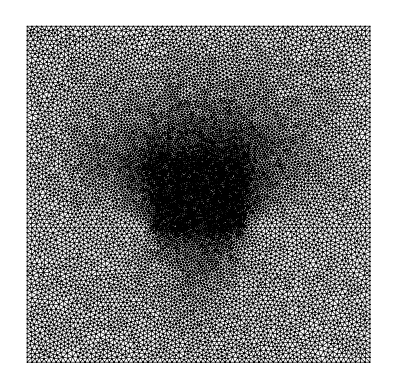

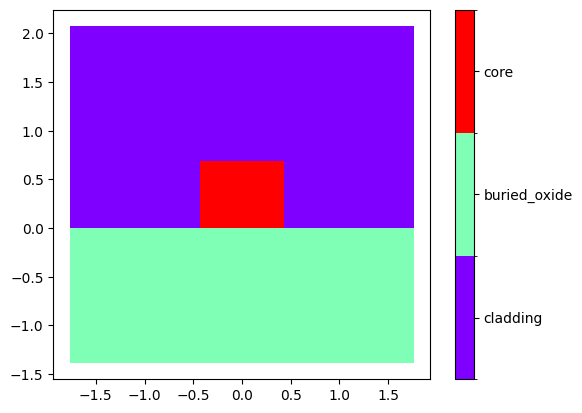

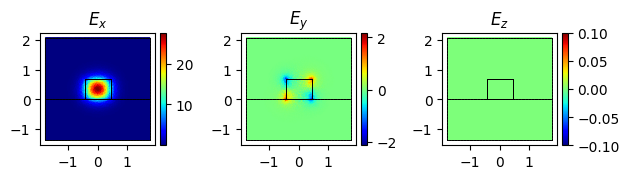

Gamma is 3.0092473438719485/W/m at pump wavelength(1.055um), 3.25/W/m in the paper


In [10]:
import shapely
from refractive_index import  n_Si3N4, n_SiO2
from collections import OrderedDict
from femwell.visualization import plot_domains
from femwell.mesh import mesh_from_OrderedDict
from femwell.maxwell.waveguide import compute_modes
from skfem import Basis, ElementTriP0
from skfem.io import from_meshio
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# waveguide parameters
width = 0.88 # um
height = 0.69 # um
length = 7.5 *1e-3 # m

n2 = 2.4e-19     # m^2/W n2 is the nonlinear refractive index at the center
Alpha = 0     # loss (dB/cm)

wavelength_range = [210,2500]
wavelegnth_step = 50

n_core = n_Si3N4
n_cladding = n_SiO2
n_buried_oxide = n_SiO2
#print(n_Si3N4(6))

# Construct waveguide geometry
core = shapely.geometry.box(-width/2, 0, +width/2, height)
cladding = shapely.geometry.box(-width*2, 0, width*2, height*3)
buried_oxide = shapely.geometry.box(-width*2,-height*2,width*2,0)
polygon = OrderedDict(
    core = core,
    cladding = cladding,
    buried_oxide = buried_oxide,
)

# Define material property and resolution of waveguide
resolutions = dict(core={"resolution": 0.02, "distance": 0.1},
                   cladding={"resolution": 0.05, "distance": 0.1},
                   buried_oxide={"resolution": 0.05, "distance": 0.1} )

n_dict = {"core": n_core,"cladding":n_cladding ,"buried_oxide": n_buried_oxide}

print("start")
# Calculate dispersion and gamma
mesh = from_meshio(mesh_from_OrderedDict(polygon, resolutions, default_resolution_max=2))
mesh.draw().show()
plot_domains(mesh)
plt.show()

basis0 = Basis(mesh, ElementTriP0())
epsilon = basis0.zeros()
wavelength_list = np.linspace(wavelength_range[0], wavelength_range[1], wavelegnth_step)
neff_list = []
aeff_list = []
te_frac_list = []


wavelength = 1.055
for subdomain, n in n_dict.items():
        epsilon[basis0.get_dofs(elements=subdomain)] = n(wavelength) ** 2
modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=3, order=1)
modes_sorted = modes.sorted(key=lambda mode: -mode.calculate_power(elements="core").real)
modes_sorted[0].show(modes_sorted[0].E.real, direction="x")
aeff = modes_sorted[0].calculate_effective_area()
gamma = 2 * np.pi * n2 / (wavelength * 1e-6 * aeff * 1e-12)
print(f"Gamma is {gamma}/W/m at pump wavelength(1.055um), 3.25/W/m in the paper")



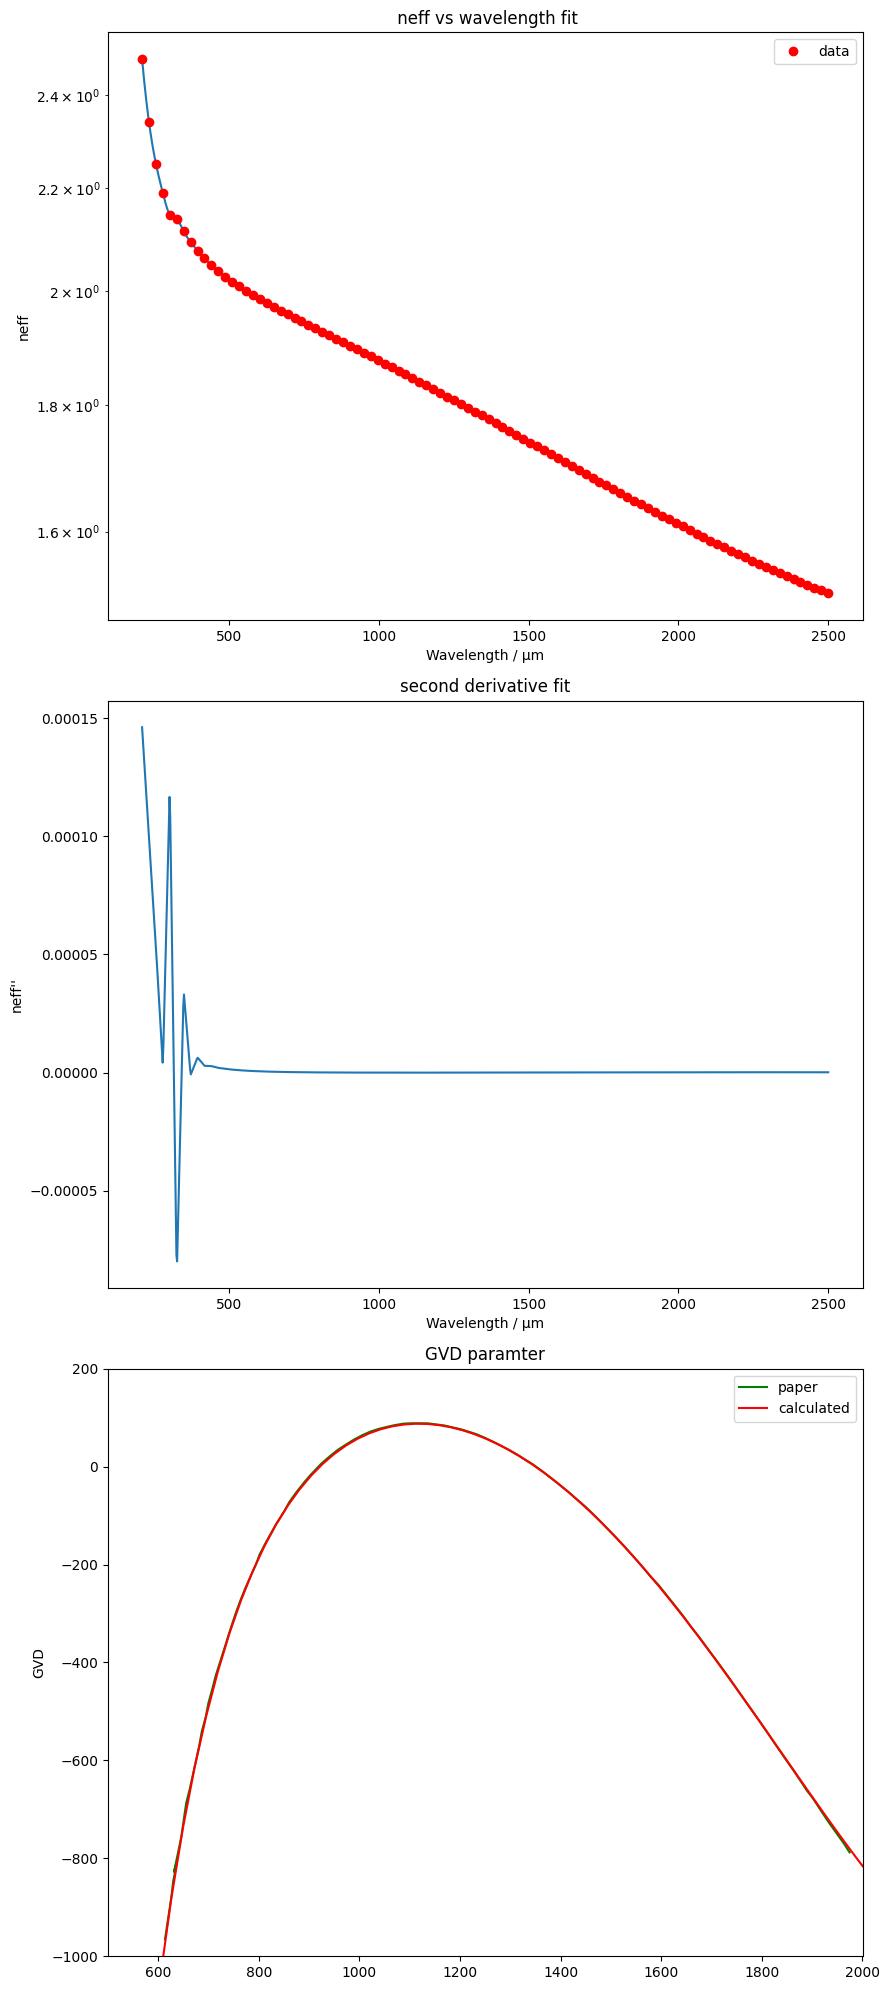

'\n\ny_spl_2d = y_spl.derivative(n=2)\nfor x in wls:\n    GVD.append(-x/(2.99792e-7 ) * y_spl_2d(x))\n\naxs.plot(wls, GVD)\naxs.set_ylim(-1000,200)\naxs.set_xlim(500,2000)\nplt.tight_layout()\nplt.show()\n\n\n'

In [1]:

from numpy.polynomial import Polynomial
import numpy as np
import matplotlib.pyplot as plt
from refractive_index import n_Si3N4
from scipy.interpolate import UnivariateSpline
from scipy.constants import speed_of_light
import pandas as pd

width = 0.88 # um
height = 0.69 # um

data = np.load(f"data_h_{height}_w_{width}.npz")
neff_list = np.array(data['neff_list'])
wls = data['wls']

fig, axs = plt.subplots(3, 1, figsize=(9,20))

y_spl = UnivariateSpline(wls,neff_list,s=0,k=3)
x_range = np.linspace(wls[0],wls[-1],1000)

axs[0].set_xlabel("Wavelength / µm")
axs[0].set_ylabel("neff")
axs[0].set_title(" neff vs wavelength fit")
axs[0].semilogy(x_range,y_spl(x_range))
axs[0].semilogy(wls,neff_list,'ro',label = 'data')
axs[0].legend()

y_spl_2d = y_spl.derivative(n=2)
axs[1].set_xlabel("Wavelength / µm")
axs[1].set_ylabel("neff''")
axs[1].set_title("second derivative fit")
axs[1].plot(x_range,y_spl_2d(x_range))



ref_gvd = pd.read_csv("../reference_data/GVD.csv", dtype=np.float64)
ref_gvd_x, ref_gvd_y = np.split(ref_gvd.values, 2, axis=1)
axs[2].plot(ref_gvd_x, ref_gvd_y, c="green", label = "paper")

GVD=(-wls/(2.99792e-7 ) * y_spl_2d(wls))
axs[2].plot(wls, GVD, label = "calculated", c="red")

axs[2].set_ylabel("GVD")
axs[2].set_ylim(-1000,200)
axs[2].set_xlim(500,2000)
axs[2].set_title("GVD paramter")
axs[2].legend()

plt.tight_layout()
plt.show()



'''

y_spl_2d = y_spl.derivative(n=2)
for x in wls:
    GVD.append(-x/(2.99792e-7 ) * y_spl_2d(x))

axs.plot(wls, GVD)
axs.set_ylim(-1000,200)
axs.set_xlim(500,2000)
plt.tight_layout()
plt.show()

'''

Use laserfun to reproduce the spectrum of Fig 5c


2.505452936956108e-08
   0.5% - 3.769e-05 m - 0.0 seconds
   1.0% - 7.538e-05 m - 0.0 seconds
   1.5% - 1.131e-04 m - 0.0 seconds
   2.0% - 1.508e-04 m - 0.0 seconds
   2.5% - 1.884e-04 m - 0.0 seconds
   3.0% - 2.261e-04 m - 0.0 seconds
   3.5% - 2.638e-04 m - 0.0 seconds
   4.0% - 3.015e-04 m - 0.0 seconds
   4.5% - 3.392e-04 m - 0.0 seconds
   5.0% - 3.769e-04 m - 0.0 seconds
   5.5% - 4.146e-04 m - 0.0 seconds
   6.0% - 4.523e-04 m - 0.0 seconds
   6.5% - 4.899e-04 m - 0.0 seconds
   7.0% - 5.276e-04 m - 0.0 seconds
   7.5% - 5.653e-04 m - 0.1 seconds
   8.0% - 6.030e-04 m - 0.1 seconds
   8.5% - 6.407e-04 m - 0.1 seconds
   9.0% - 6.784e-04 m - 0.1 seconds
   9.5% - 7.161e-04 m - 0.1 seconds
  10.1% - 7.538e-04 m - 0.1 seconds
  10.6% - 7.915e-04 m - 0.1 seconds
  11.1% - 8.291e-04 m - 0.1 seconds
  11.6% - 8.668e-04 m - 0.1 seconds
  12.1% - 9.045e-04 m - 0.1 seconds
  12.6% - 9.422e-04 m - 0.1 seconds
  13.1% - 9.799e-04 m - 0.1 seconds
  13.6% - 1.018e-03 m - 0.1 seconds
  14.1

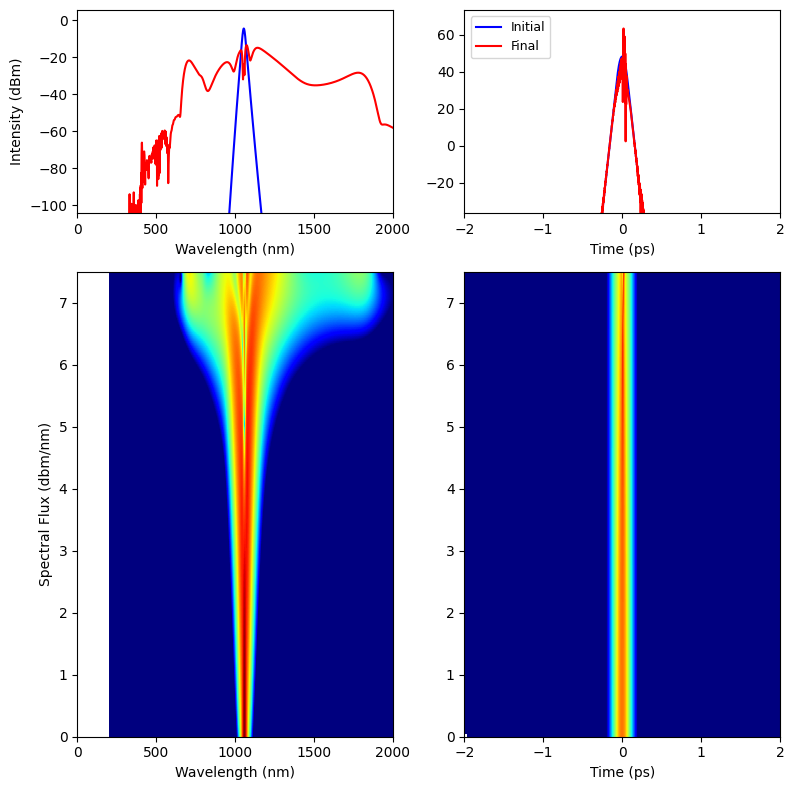

In [2]:

import laserfun as lf
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

# waveguide parameters
width = 0.88 # um
height = 0.69 # um
length = 7.5 * 1e-3

n2 = 2.4e-19     # m^2/W n2 is the nonlinear refractive index at the center
Alpha = 0.0     # loss (dB/cm)

# pulse parameters
FWHM = 80 * 1e-3  # pulse duration (ps)
pulseWL = 1055  # pulse central wavelength (nm)
frep_MHz = 1.025 * 1e9
epp = 26 * 1e-12
power = 1.8

chirp = 800 *1e-6  #ps^2

GDD = True   # Group delay dispersion (ps^2)
TOD = False  # Third order dispersion (ps^3)
FOD = False  # Fourth order dispersion

# simulation parameters
Window = 4  # simulation window (ps)
Steps = 200  # simulation steps
Points = 2 ** 14  # simulation points
rtol = 1e-4  # relative error for NLSE integrator
atol = 1e-4  # absolute error
Raman = True  # Enable Raman effect?
Steep = True  # Enable self steepening?


data = np.load(f"data_h_{height}_w_{width}.npz")
wls = data['wls']
neff_list = data['neff_list']
aeff_list = data['aeff_list']


def disp_function(z=0):  # provide effective index to the NLSE
    return (wls, neff_list)


# Calculate Gamma
def gamma_function(pump_wl):  # provide the nonlinearity at the pump to the NLSE
    aeff_interp = scipy.interpolate.interp1d(wls, aeff_list)
    gamma = 2 * np.pi * n2 / (pump_wl * 1e-9 * aeff_interp(pump_wl) * 1e-12)
    return gamma

# create the pulse:
p = lf.Pulse(pulse_type='sech', fwhm_ps=FWHM, center_wavelength_nm=pulseWL,
             time_window_ps=Window, power_is_avg=True,power= power, wav=wls,RI=neff_list, GDD=GDD,TOD=TOD, FOD=FOD, npts=Points, epp = epp)
p.chirp_pulse_W(chirp)

# create the waveguide
f = lf.Fiber(length, center_wl_nm=pulseWL, dispersion_format='GVD',
             gamma_W_m=gamma_function(pulseWL), loss_dB_per_m=Alpha * 100)

f.set_dispersion_function(disp_function, dispersion_format='n')

# propagate the pulse using the NLSE
results = lf.NLSE(p, f, raman=Raman, shock=Steep, nsaves=Steps, rtol=rtol,
                  atol=atol, print_status=True)
#Plot adjusting


fig, axes = results.plot(wavelength=True, show=False, tlim=(-2, 2), flim=(0, 2000), wmax = 8000, wmin = 200)

plt.set_cmap('jet')
plt.show()